In [1]:
%matplotlib inline

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RANSACRegressor

# RANSAC Houses Demo

## Housing dataset

Data from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/).

### Prepare data

- read
- set column names
- get to know
    - shape
    - dtypes
- separate predictor and target variables
- normalize
- train test split
- model with linear regression


In [9]:
housing = pd.read_fwf("../datasets/housing/housing.data", header = None)
housing.columns = ["crime_rate", "zoned_land", "industry", "bounds_river", "nox_conc", "rooms", "age", "distance",  "highways", "tax", "pt_ratio", "b_estimator", "pop_status", "price"]
housing.head()

,crime_rate,zoned_land,industry,bounds_river,nox_conc,rooms,age,distance,highways,tax,pt_ratio,b_estimator,pop_status,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [13]:
housing.shape

(506, 14)

In [10]:
housing.dtypes

crime_rate      float64
zoned_land      float64
industry        float64
bounds_river      int64
nox_conc        float64
rooms           float64
age             float64
distance        float64
highways          int64
tax             float64
pt_ratio        float64
b_estimator     float64
pop_status      float64
price           float64
dtype: object

In [12]:
housing_attributes = housing.drop(columns="price")
housing_prices = housing.price

housing_attributes.shape, housing_prices.shape

((506, 13), (506,))

In [29]:
scaler = MinMaxScaler()
housing_attributes_scaled = scaler.fit_transform(housing_attributes)


first_record = pd.DataFrame({
    "before scaling": housing_attributes.iloc[0],
    "after scaling": housing_attributes_scaled[0],
})

first_record

,before scaling,after scaling
crime_rate,0.00632,0.000000
zoned_land,18.00000,0.180000
industry,2.31000,0.067815
bounds_river,0.00000,0.000000
nox_conc,0.53800,0.314815
rooms,6.57500,0.577505
age,65.20000,0.641607
distance,4.09000,0.405722
highways,1.00000,0.000000
tax,296.00000,0.208015


In [31]:
housing_attributes_train, housing_attributes_test, \
housing_prices_train, housing_prices_test \
= train_test_split(housing_attributes_scaled, housing_prices, train_size=0.8)


for data_set in [
    housing_attributes_train, housing_attributes_test, \
    housing_prices_train, housing_prices_test,
]:
    print(data_set.shape)

(404, 13)
(102, 13)
(404,)
(102,)


### Model data

#### Linear regression

In [57]:
housing_lin_reg = LinearRegression()

In [58]:
housing_lin_reg.fit(housing_attributes_train, housing_prices_train)

LinearRegression()

In [59]:
predicted = housing_lin_reg.predict(housing_attributes_test[:10])
predicted = predicted.round(1)

actual = housing_prices_test[:10]

print("Predicted vs known (observed) prices")
pd.DataFrame({
    "actual": actual,
    "predicted": predicted,
})

Predicted vs known (observed) prices


,actual,predicted
29,21.0,22.3
367,23.1,6.2
454,14.9,15.0
81,23.9,26.9
149,15.4,16.0
233,48.3,38.1
182,37.9,33.4
440,10.5,13.2
436,9.6,13.3
400,5.6,13.5


In [60]:
R2_train = housing_lin_reg.score(housing_attributes_train, housing_prices_train)
R2_test = housing_lin_reg.score(housing_attributes_test, housing_prices_test)

print(
    f"R_squared on training data: {R2_train:0.2f}",
    f"R_squared on testing data: {R2_test:0.2f}",
    sep="\n",
)

R_squared on training data: 0.72
R_squared on testing data: 0.70


In [61]:
housing_lin_reg.coef_

array([ 2.16871490e+00,  1.61685273e+00, -2.10678917e-02,  3.04238449e+00,
       -6.63531807e+00,  2.55902468e+01,  5.81206393e-01, -8.59790921e+00,
        4.88600713e-01, -1.08084232e+00, -8.29814616e+00,  5.92520174e+00,
       -1.75119555e+01])

In [62]:
housing_lin_reg.intercept_

18.79865593274045

#### RANSAC

There are 13 pcs predictor variables + 1 intercept => therefore set min_samples=14.

In [116]:
housing_ransac = RANSACRegressor(
    estimator=LinearRegression(),
    min_samples=20,
    max_trials=200,
    loss='squared_error',
)

In [117]:
housing_ransac.fit(housing_attributes_train, housing_prices_train)

RANSACRegressor(estimator=LinearRegression(), loss='squared_error',
                max_trials=200, min_samples=20)

In [118]:
housing_ransac.n_trials_

200

#### Weights

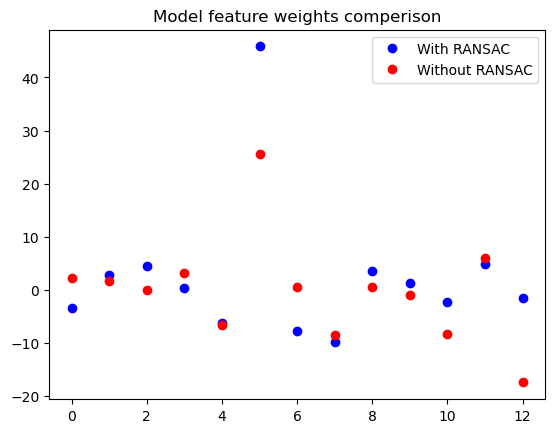

In [119]:
ransac_coef = housing_ransac.estimator_.coef_
linreg_coef = housing_lin_reg.coef_

plt.plot(ransac_coef, 'bo', label='With RANSAC')
plt.plot(linreg_coef, 'ro', label='Without RANSAC')

plt.title("Model feature weights comperison")
plt.legend()
plt.show()

#### Scores

In [120]:
linreg_score = housing_lin_reg.score(housing_attributes_train, housing_prices_train)
ransac_overall_score = housing_ransac.score(housing_attributes_train, housing_prices_train)

# Inliers
housing_attributes_train_inliers = housing_attributes_train[housing_ransac.inlier_mask_]
housing_prices_train_inliers = housing_prices_train[housing_ransac.inlier_mask_]
ransac_inlier_score = housing_ransac.estimator_.score(housing_attributes_train_inliers, housing_prices_train_inliers)

# Outliers
housing_attributes_train_outliers = housing_attributes_train[~housing_ransac.inlier_mask_]
housing_prices_train_outliers = housing_prices_train[~housing_ransac.inlier_mask_]
ransac_outlier_score = housing_ransac.estimator_.score(housing_attributes_train_outliers, housing_prices_train_outliers)


print(
    "R_squared Comparison Training Data",
    "-" * 30,
    f"Without RANSAC: {linreg_score:.2f}",
    f"With RANSAC, all points: {ransac_overall_score:.2f}",
    f"With RANSAC, inliers: {ransac_inlier_score:.2f}",
    f"With RANSAC, outliers: {ransac_outlier_score:.2f}",
    sep="\n",
)

R_squared Comparison Training Data
------------------------------
Without RANSAC: 0.72
With RANSAC, all points: 0.61
With RANSAC, inliers: 0.97
With RANSAC, outliers: 0.53


In [121]:
linreg_score = housing_lin_reg.score(housing_attributes_test, housing_prices_test)
ransac_score = housing_ransac.estimator_.score(housing_attributes_test, housing_prices_test)

print(
    "R_squared Comparison Test Data",
    "-" * 30,
    f"Without RANSAC: {linreg_score:.2f}",
    f"With RANSAC: {ransac_score:.2f}",
    sep="\n",
)

R_squared Comparison Test Data
------------------------------
Without RANSAC: 0.70
With RANSAC: 0.57


#### Plots

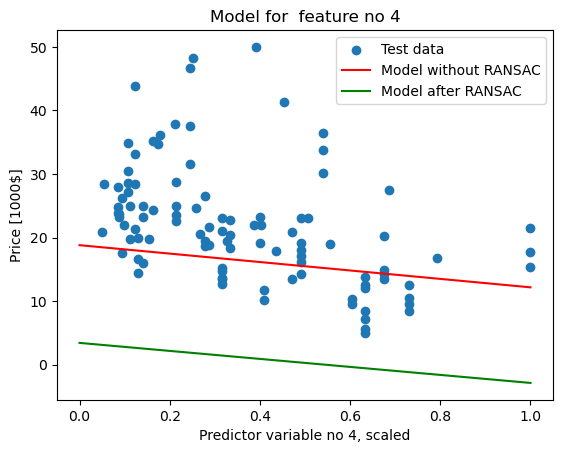

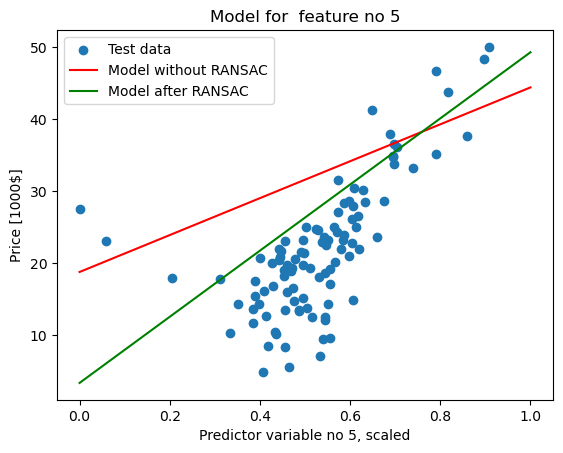

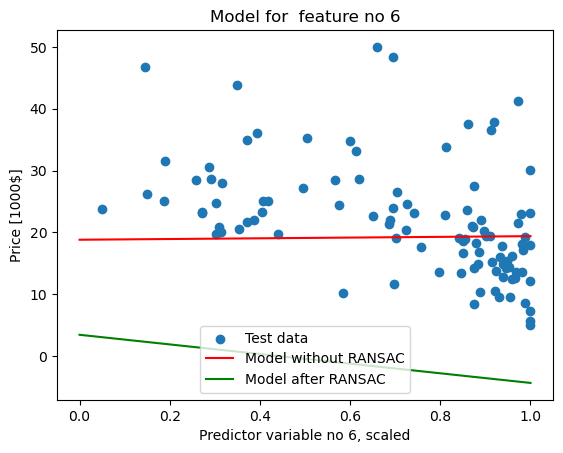

In [122]:
def plot_model_for_single_variable(variable_number):
    x = housing_attributes_test[:, variable_number]
    y = housing_prices_test
    plt.scatter(x, y, label="Test data")

    x2 = np.linspace(0, 1, 2)
    y2 = housing_lin_reg.coef_[variable_number] * x2 + housing_lin_reg.intercept_
    plt.plot(x2, y2, 'red', label="Model without RANSAC")

    x3 = np.linspace(0, 1, 2)
    y3 = housing_ransac.estimator_.coef_[variable_number] * x3 + housing_ransac.estimator_.intercept_
    plt.plot(x3, y3, 'green', label="Model after RANSAC")

    plt.xlabel(f"Predictor variable no {variable_number}, scaled")
    plt.ylabel("Price [1000$]")
    plt.title(f"Model for  feature no {variable_number}")
    plt.legend()
    plt.show()
    
for variable_number in [4,5,6]:
    plot_model_for_single_variable(variable_number)